<a href="https://colab.research.google.com/github/danny980521/BOAZ_Analysis_Mentoring_A/blob/main/3%264.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3장

##3.1 MNIST

In [ ]:
#mnist 데이터 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

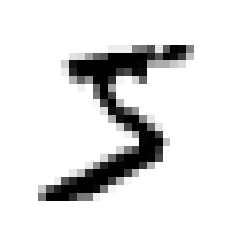

In [ ]:
#이미지 하나 확인
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [ ]:
#실제 레이블 확인
y[0]

'5'

In [ ]:
#y를 정수로 변환
import numpy as np

y = y.astype(np.uint8)

In [ ]:
#train, test split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

##3.2 이진 분류기 훈련

In [ ]:
#5인지 아닌지를 분류하기 위한 타깃 벡터 생성
y_train_5 = (y_train == 5) # 5는 True고， 다른 숫자는 모두 False 
y_test_5 = (y_test == 5)

In [ ]:
#SGDClassifier 모델 생성
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
#some_digit 이미지 감지 (정답 = 5)
sgd_clf.predict([some_digit])

array([ True])

##3.3 성능 측정

###3.3.1 교차 검증을 사용한 정확도 측정

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [ ]:
#cross_val_score를 이용한 k-fold
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
#무조건 5아님 분류기 제작 및 성능 확인
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator): 
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

###3.3.2 오차 행렬

In [ ]:
#자체 예측 결과 생성
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
#오차 행렬 생성
from sklearn.metrics import confusion_matrix 

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
# 완벽한 분류기일 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

###3.3.3 정밀도와 재현율

In [ ]:
#정밀도 계산
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
#재현율 계산
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
#f1 스코어 계산
from sklearn.metrics import f1_score 

f1_score(y_train_5, y_train_pred)

0.7325171197343846

###3.3.4 정밀도/재현율 트레이드오프

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
#임계값을 0으로 설정해 predict()와 같은 결과 반환
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
#임계값을 8000으로 설정
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
#결정 점수를 반환하도록 cross_val_predict()
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [ ]:
#모든 임계값에 대한 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

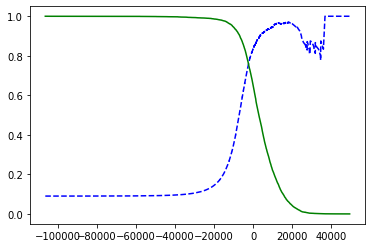

In [ ]:
#함수로 시각화
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율" )

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
#정밀도 90% 달성을 위한 임계값 탐색
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [ ]:
#이 임계값에 대한 정밀도 체크
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
#이 임계값에 대한 재현율 체크
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

###3.3.5 ROC 곡선

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

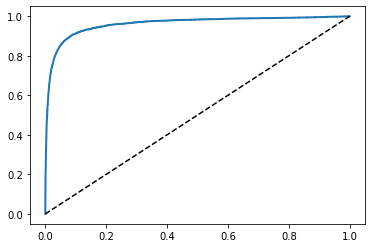

In [ ]:
#ROC 곡선 그리기
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
#AUC 측정
from sklearn.metrics import roc_auc_score 

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
#랜덤포레스트로 훈련시켜 ROC점수와 AUC 점수 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba" )

In [ ]:
# 앙성 클래스에 대한 확률을 접수로 사용
y_scores_forest = y_probas_forest[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47004 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_

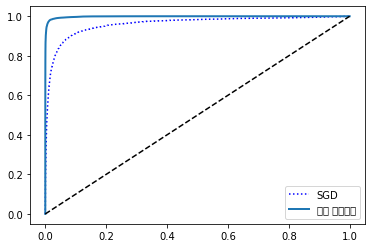

In [ ]:
#ROC 곡선 그리기
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

In [ ]:
#AUC 측정
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

##3.4 다중 분류

In [ ]:
#서포트 벡터 머신 분류기를 이용한 다중 분류 테스트
from sklearn.svm import SVC 

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
#클래스 당 부여한 점수 확인
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

In [ ]:
#SVC 기반 OvR 전략을 사용하는 다중 분류기 제작
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
#SGD 기반 다중 분류기 제작
#SGD는 직접 샘플을 다중 클래스로 분류할 수 있어 OvR, OvO등의 전략을 적용하지 않아도 된다.
sgd_clf.fit(X_train, y_train) 
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
#클래스 당 부여한 점수 확인
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
#교차검증을 이용해 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
#입력 스케일 조정 후 정확도 평가
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

##3.5 에러 분석

In [ ]:
#오차 행렬 호출
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) 
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

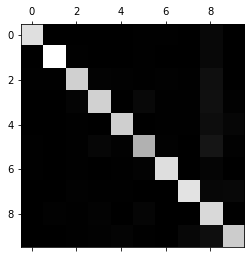

In [ ]:
#오차 행렬을 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
#오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

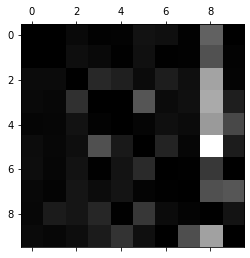

In [ ]:
#주대각선을 0으로 채워 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

##3.6 다중 레이블 분류

In [ ]:
#숫자가 7보다 큰지, 홀수인지를 다중으로 분류하기
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd =(y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
#5에 대해 예측
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
#f1 스코어의 평균을 계산해 다중 레이블 분류기 평가하기
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

##3.7 다중 출력 분류

In [ ]:
#mnist 이미지에서 추출한 훈련 세트와 테스트 세트에 randint()를 이용해 잡음 추가하기
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
#분류기를 훈련시켜 잡음 없애기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

#4 모델 훈련

##4.1 선형 회귀

###4.1.1 정규방정식

In [4]:
#잡음을 섞은 선형 데이터 생성
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [5]:
#정규방정식을 사용해 theta 계산
X_b = np.c_[np.ones((100, 1)), X] # 모든 샘플에 x0 = 1을 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [6]:
#계산한 값을 본래 식 y = 4 + 3x1 + 가우시안 잡음과 비교
theta_best

array([[3.78933891],
       [3.1186272 ]])

In [7]:
#theta를 사용해 예측
X_new = np.array([[0], [2]]) 
X_new_b = np.c_[np.ones((2, 1)),X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.78933891],
       [10.02659331]])

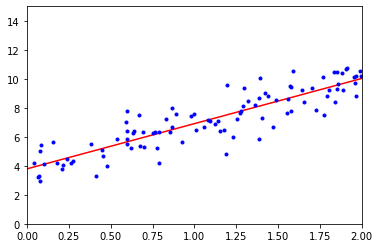

In [10]:
#모델 예측을 그래프에 표현
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [11]:
#사이킷런을 이용한 선형 회귀 수행
from sklearn.linear_model import LinearRegression 
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.78933891]), array([[3.1186272]]))

In [12]:
lin_reg.predict(X_new)

array([[ 3.78933891],
       [10.02659331]])

In [14]:
#scipy.linalg.lstsq()를 직접 호출하여 계산
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.78933891],
       [3.1186272 ]])

In [15]:
#np.linalg.pinv() 함수를 이용해 유사역행렬 직접 계산
np.linalg.pinv(X_b).dot(y)

array([[3.78933891],
       [3.1186272 ]])

##4.2 경사 하강법

###4.2.1 배치 경사 하강법

In [19]:
#배치 경사 하강법 구현
eta =0.1 # 학습률 
n_iterations = 1000 
m = 100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

theta

array([[3.78933891],
       [3.1186272 ]])

###4.2.2 확률적 경사 하강법

In [22]:
#간단한 학습 스케줄을 사용한 확률적 경사 하강법 구현
n_epochs = 50
t0, t1 = 5, 50 # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # 무작위 초기화

for epoch in range(n_epochs): 
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2*xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
theta

array([[3.76293912],
       [3.16289671]])

In [23]:
#SGDRegressor 클래스를 이용한 선형회귀
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol=1e-3, penalty=None, eta0 = 0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [24]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.71076787]), array([3.10535925]))

##4.3 다항 회귀

In [26]:
#2차 방정식을 이용해 비선형 데이터 생성
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [27]:
#훈련 세트에 있는 각 특성을 제곱하여 새로운 특성으로 추가
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([1.59636606])

In [28]:
X_poly[0]

array([1.59636606, 2.54838461])

In [29]:
#Linear Regression 적용
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.99004525]), array([[0.90836776, 0.4873688 ]]))

##4.4 학습 곡선

In [33]:
#주어진 훈련 데이터에서 모델의 학습 곡선을 그리는 함수 정의
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y) :
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[ :m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련 세트")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label=" 검증 세트" )

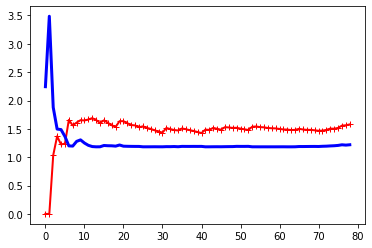

In [34]:
#단순 선형 회귀 모델(직선)의 학습 곡선
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

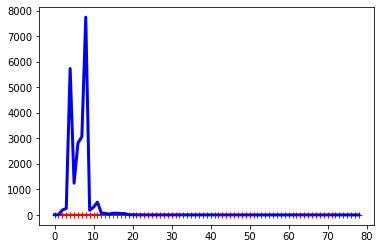

In [36]:
#10차 다항 선형 회귀 모델의 학습 곡선
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly-features" , PolynomialFeatures(degree=10, include_bias=False)), 
    ("linJeg", LinearRegression()),
    ]) 

plot_learning_curves(polynomial_regression, X, y)

##4.5 규제가 있는 선형 모델

###4.5.1 릿지 회귀

In [39]:
#릿지 회귀의 정규방정식 적용
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1 , solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.95903557]])

In [41]:
#확률적 경사 하강법의 l2 패널티 적용
sgd_reg = SGDRegressor(penalty="l2") 
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.94096359])

###4.5.2 라쏘 회귀

In [42]:
#라쏘 회귀 구현
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.91735327])

###4.5.3 엘라스틱넷

In [43]:
#엘라스틱넷 구현
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.91875562])

###4.5.4 조기종료

In [49]:
#SGDRegressor에 조기 종료 적용
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

# 데이터 준비 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler()) 
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000) :
    sgd_reg.fit(X_train_poly_scaled, y_train) # 훈련을 이어서 진행합니다. 
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error :
        minimum_val_error = val_error 
        best_epoch = epoch
        best_model = clone(sgd_reg)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

##4.6 로지스틱 회귀

###4.6.3 결정 경계

In [50]:
#iris 데이터 로드
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [51]:
X = iris["data"][:, 3:] # 꽃잎의 너비
y = (iris["target"] == 2).astype(np.int) # 1 Iris-띠rginica면 L 그렇지 않으면 8

In [52]:
#로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

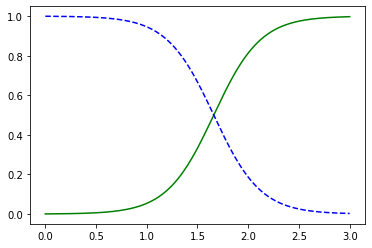

In [53]:
#꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률 계산
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="lris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not lris virginica")

In [54]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

###4.6.4 소프트맥스 회귀

In [55]:
#LogisticRegression의 multi_class 매개변수를 "multinomial"로 비꾸어 소프트맥스 회귀를 사용
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비 
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10) 
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
#붗꽃의 품종 에측
softmax_reg.predict([[5, 2]])

array([2])

In [57]:
#각 클래스에 속할 확률 에측
softmax_reg .predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])